In [1]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

from open_data  import matlab_file
from structure_data import  manage, struct_tools
from measures import ISI, FiringRate, tools
from classify import HistGrad

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms


import os
import sys

%load_ext autoreload
%autoreload 2

# Load and format data

### Load data

In [2]:
#Load
session, data_path, info_path = matlab_file.from_lab(lab_desktop=True, session='t150204001')
data, load_info = matlab_file.open(data_path)
session_info_raw = matlab_file.clean(info_path)


43 files loaded


In [3]:
# get sessions and units information (unit, prob, elitrials)
info_units,  info_session = manage.info(load_info, session_info_raw, session)
unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = manage.units_label(info_units)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(manage.elitrials)
# get unit's index without eli trials 
completeUnit = manage.CompleteTasktime(info_session, load_info, session)
unit_label[:5]

Complete unit found ! 
loading index = 2
matfile : t150204001_probe1_contact3_unit1.mat


['P1-23-2', 'P1-5-1', 'P1-3-1', 'P1-1-1', 'P2-6-1']

In [4]:
spike_times, task_times, target_info = matlab_file.extract_data(\
        load_info, data, target_keys_OFF=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'],\
        target_keys_ON=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], \
        event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

### Format spike times 

In [5]:
event_labels = matlab_file.get_event_labels(task_times)
event_times = matlab_file.get_event_times(task_times, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = manage.events_by_trial(event_times, event_labels)

In [6]:
unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {task_times[0][1].keys()}')


times as list : [3047992 3049069 3050391 3051713 3053021 3054320 3054799]
times as neo events : [3047992. 3049069. 3050391. 3051713. 3053021. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time'])


In [7]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


### Format target

In [8]:
target = manage.target_by_trials(target_info, completeUnit)
target

,trial_type,position,type_and_pos
0,1,2,0
1,1,2,0
2,1,3,1
3,1,3,1
4,1,4,2
...,...,...,...
171,1,3,1
172,2,3,4
173,2,4,5
174,2,4,5


### Format trials

In [9]:
# align times by trials for each neurons
df_task_ts_by_neuron = manage.time_by_trials(df_task_ts_by_neuron, df_task_ts, event_labels)
df_task_ts_by_neuron[0][1]

# split the spike time vector by trial
spk_trials, spike_train_trial = manage.spike_ts_by_trial(trials_ts, spike_times)
spikes_times_aligned = manage.spike_ts_aligned(df_task_ts, df_task_ts_by_neuron, spike_times, unit_label, spike_train_trial)

/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:360: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.iloc[idx_trial_valid][1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:361: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.iloc[idx_trial_valid][-1]
/home/INT/mifsud.l/Bureau/pattern_classification_git/pipeline_drafts/structure_data/manage.py:383: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent 

# Raster plot

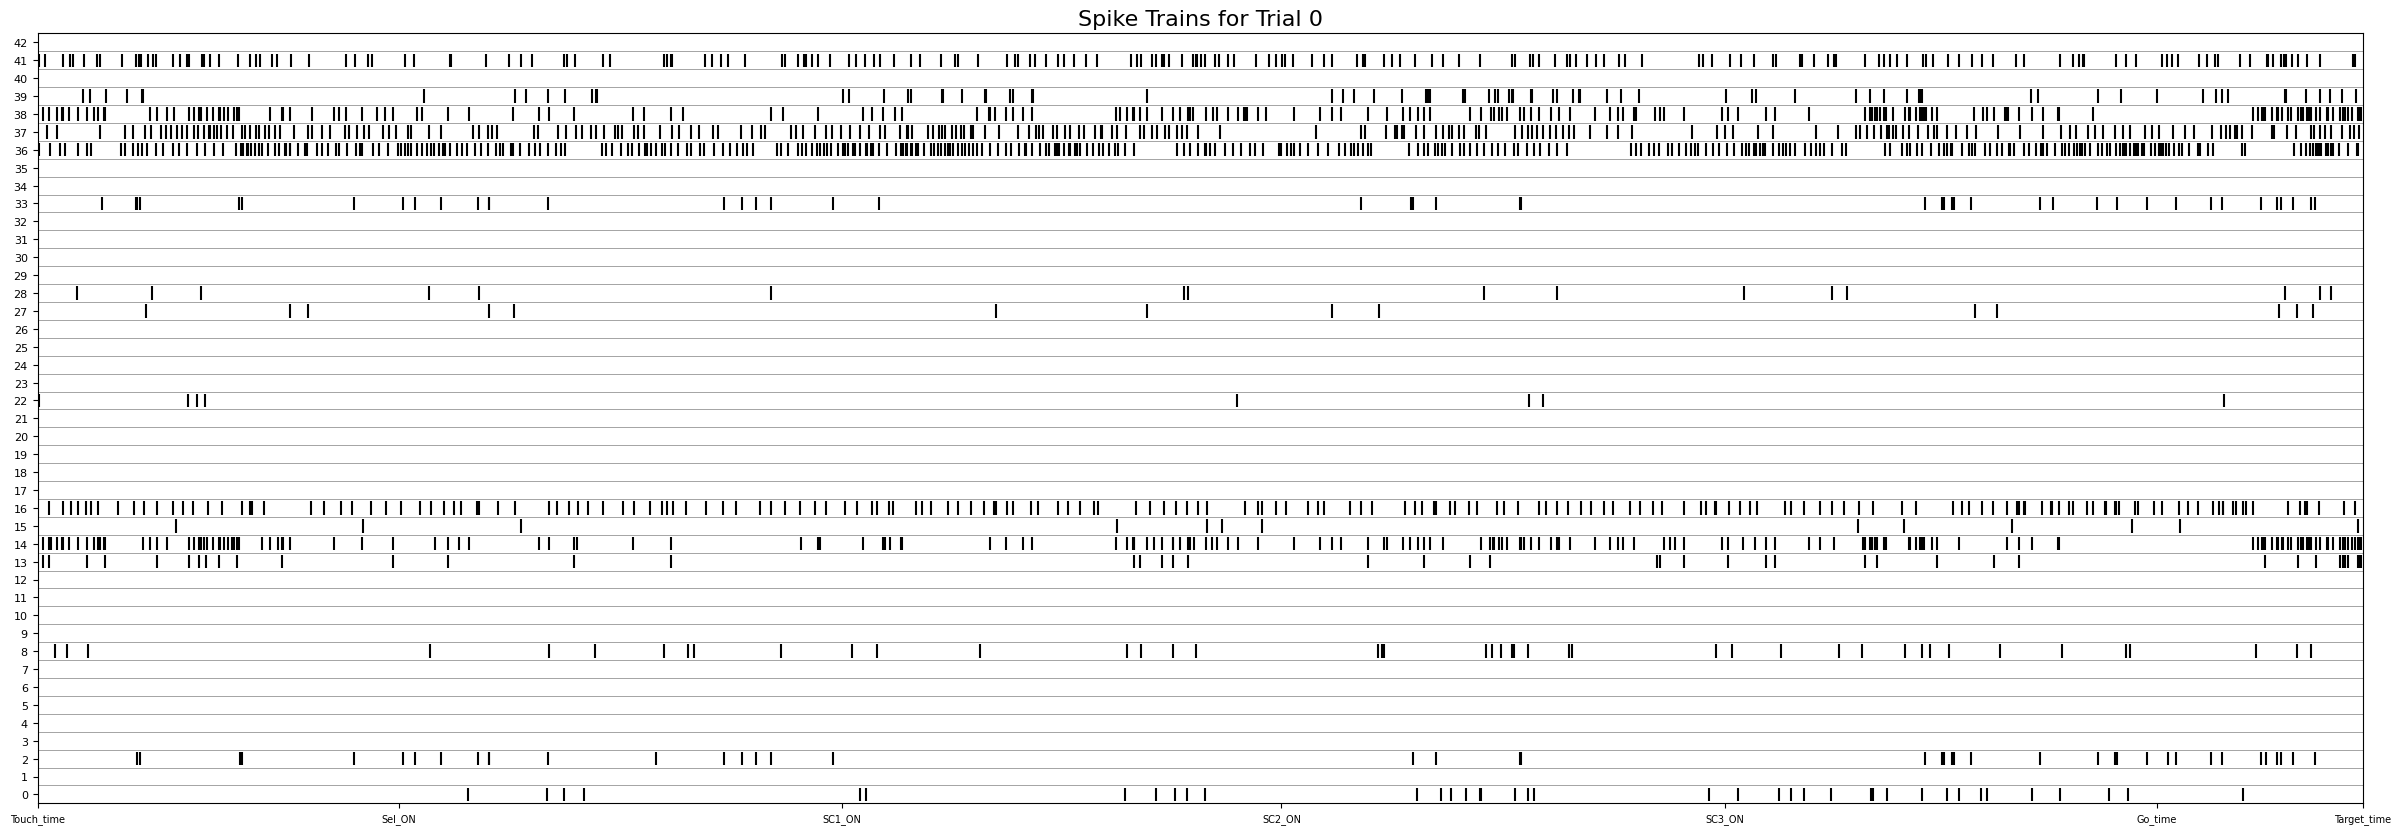

In [10]:
n_neurons = spikes_times_aligned.shape[0]
n_trials = spikes_times_aligned.shape[1]

t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(30, 10))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


In [11]:
import numpy as np

def get_spike_times_vect(spikes_times_aligned):
    n_trials = spikes_times_aligned.shape[1]
    n_neurons = spikes_times_aligned.shape[0]
    spk_times = np.zeros((n_trials, n_neurons), dtype=object)
    last_spike = np.full((n_trials, n_neurons), np.nan)

    for n in range(n_neurons):
        for t in range(n_trials):
            if (spikes_times_aligned[n][t]['spike_time'].size > 0) and (spikes_times_aligned[n][t]['spike_time'][0] != 0):
                spk_times[t, n] = spikes_times_aligned[n][t]['spike_time']
                last_spike[t, n] = spikes_times_aligned[n][t]['spike_time'].max()
            else:
                # Handle the case when the array is empty
                spk_times[t, n] = np.full(1, -1)
                last_spike[t, n] = np.array(-1)  # Or any other value you deem appropriate

    # Concatenate while preserving NaN values
    concatenated_spk_times = []
    for spk_time in spk_times.flatten():
        if isinstance(spk_time, np.ndarray):
            concatenated_spk_times.extend(spk_time)
        else:
            concatenated_spk_times.append(np.array(np.nan))

    return np.array(concatenated_spk_times), last_spike, spk_times


In [12]:
spike_times_vec, last_spikes, spk_ts = get_spike_times_vect(spikes_times_aligned)

In [13]:
epochs = struct_tools.create_epochs(spikes_times_aligned)
channels = np.arange(0, n_neurons)

In [14]:
ii_spike_times = np.zeros((len(epochs), len(channels), 2), dtype=int)

start_idx = 0
for epoch_idx, epoch in enumerate(epochs):
    for channel_idx, channel in enumerate(channels):
        ii_spike_times[epoch_idx, channel_idx, 0] = start_idx
        stop_idx = start_idx + spk_ts[epoch_idx,channel_idx].shape[0]
        ii_spike_times[epoch_idx, channel_idx, 1] = stop_idx
        start_idx = stop_idx

In [15]:
print ("ii_spike_times.shape", ii_spike_times.shape)
print ("# epochs =", ii_spike_times.shape[0])
print ("# neurons =",ii_spike_times.shape[1])

ii_spike_times.shape (176, 43, 2)
# epochs = 176
# neurons = 43


# SpikeShip Demo

In [16]:
from spikeship import spikeship, tools

/home/INT/mifsud.l/env_classif_0423/lib/python3.11/site-packages/numba/core/decorators.py:250: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [17]:
%%time
spike_times = spike_times_vec
epoch_labels = target_info[completeUnit][1]['Trial_type']
spikeship_diss = spikeship.distances(spike_times, ii_spike_times)

CPU times: user 2.78 s, sys: 5.79 ms, total: 2.78 s
Wall time: 182 ms


In [72]:
a = epoch_labels.tolist()

In [74]:
np.argsort(a)

array([  0,  71,  70,  69,  68,  67,  66,  65,  64,  62,  61,  60,  59,
        58,  57,  56,  72,  55,  73, 108, 123, 122, 121, 120, 119, 118,
       117, 116, 115, 114, 113, 112, 111, 110, 109, 107,  54,  63,  16,
        17,  15,  14,  13,  12,  11,   9,   8,  10,   6,   5,   4,   3,
         2,   1,  19,  18,   7,  83,  78,  79,  80,  81,  37,  84,  82,
        86,  87,  88,  89,  90,  91,  77, 124, 125,  85,  76, 127,  74,
        34,  33,  75,  35,  32,  31,  30,  29,  28,  36,  27,  26,  25,
        24,  20,  23,  21, 126,  22,  52,  51,  50,  49,  46,  47,  45,
        44,  43,  42,  41,  39,  48,  40, 102, 106, 105, 104, 103, 101,
       100,  99,  98,  97,  96,  95,  94,  93,  92,  53,  38])

In [46]:
epoch_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2],
      dtype=uint8)

In [76]:
import numpy as np

# Votre tableau
epoch_labels = np.array([
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 
    2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 
    3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 
    1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 
    3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 
    1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2
], dtype=np.uint8)

# Obtenez les indices triés
indices_tries = np.argsort(epoch_labels)

# Affichez les indices triés
print("Indices triés:", indices_tries)

# Utilisez ces indices pour obtenir le tableau trié
epoch_labels_tries = epoch_labels[indices_tries]
print("Tableau trié:", epoch_labels_tries)



Indices triés: [  0  68  67  66  65  64  63  62  61  60  59  58  57  56  55  54  69 106
  70  72 107 108 109 110 111 112 113 114 115 116 117 118 119 120  73  71
 155 105 167  19  16  15 170 169 168 156 166 165 164 163 162 161 160 159
 158  14   1   2   3   4   5 157  18   6   8   9  10  11  12  13   7  17
 136 171 135 134 133 132 131 129 172 128 126 125 124 123 122 121 127 130
  87 174  83  82  81  80  78  77  84  76  74  33  34  35  36  90  75  85
  79 173  20  86  22  23  24  25  26  27  21  29  30  31  32  89  28  88
 143 144 145 146 147 148 151 150 152 153 154  37 142 149 141  91 139  92
  93  94  95  96  97  98  99 100 101 102 103 104  53 140  52  50  49  48
  47  46  45  44  43  41  40  39  38 137 138  51  42]
Tableau trié: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 

In [106]:
epoch_labels[:55]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1], dtype=uint8)

In [90]:
si = np.concatenate([np.arange(epoch_labels.size)[epoch_labels==i+1] for i in range(3)])

In [81]:
epoch_labels
si = np.argsort(epoch_labels)
si


array([  0,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,  57,
        56,  55,  54,  69, 106,  70,  72, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120,  73,  71, 155, 105, 167,
        19,  16,  15, 170, 169, 168, 156, 166, 165, 164, 163, 162, 161,
       160, 159, 158,  14,   1,   2,   3,   4,   5, 157,  18,   6,   8,
         9,  10,  11,  12,  13,   7,  17, 136, 171, 135, 134, 133, 132,
       131, 129, 172, 128, 126, 125, 124, 123, 122, 121, 127, 130,  87,
       174,  83,  82,  81,  80,  78,  77,  84,  76,  74,  33,  34,  35,
        36,  90,  75,  85,  79, 173,  20,  86,  22,  23,  24,  25,  26,
        27,  21,  29,  30,  31,  32,  89,  28,  88, 143, 144, 145, 146,
       147, 148, 151, 150, 152, 153, 154,  37, 142, 149, 141,  91, 139,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
        53, 140,  52,  50,  49,  48,  47,  46,  45,  44,  43,  41,  40,
        39,  38, 137, 138,  51,  42])

In [99]:
epoch_labels_sorted = np.sort(epoch_labels)

In [64]:
sorted_indices

array([  0,  71,  70,  69,  68,  67,  66,  65,  64,  62,  61,  60,  59,
        58,  57,  56,  72,  55,  73, 108, 123, 122, 121, 120, 119, 118,
       117, 116, 115, 114, 113, 112, 111, 110, 109, 107,  54,  63,  16,
        17,  15,  14,  13,  12,  11,   9,   8,  10,   6,   5,   4,   3,
         2,   1,  19,  18,   7,  83,  78,  79,  80,  81,  37,  84,  82,
        86,  87,  88,  89,  90,  91,  77, 124, 125,  85,  76, 127,  74,
        34,  33,  75,  35,  32,  31,  30,  29,  28,  36,  27,  26,  25,
        24,  20,  23,  21, 126,  22,  52,  51,  50,  49,  46,  47,  45,
        44,  43,  42,  41,  39,  48,  40, 102, 106, 105, 104, 103, 101,
       100,  99,  98,  97,  96,  95,  94,  93,  92,  53,  38])

([<matplotlib.axis.XTick at 0x7f1d93c671d0>,
 [Text(0, 0, '1'),
  Text(10, 0, '1'),
  Text(20, 0, '2'),
  Text(30, 0, '2'),
  Text(40, 0, '3'),
  Text(50, 0, '3'),
  Text(60, 0, '1'),
  Text(70, 0, '1'),
  Text(80, 0, '2'),
  Text(90, 0, '2'),
  Text(100, 0, '3'),
  Text(110, 0, '1'),
  Text(120, 0, '1'),
  Text(130, 0, '2'),
  Text(140, 0, '3'),
  Text(150, 0, '3'),
  Text(160, 0, '1'),
  Text(170, 0, '1')])

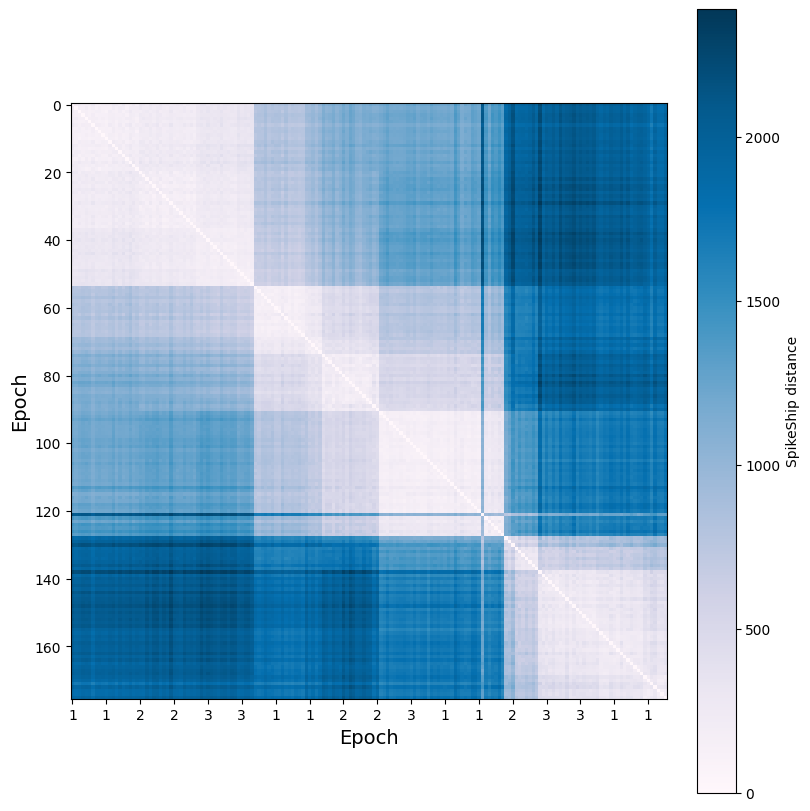

In [101]:
alpha = 0.5; marker = 'o';

# true labels sorting
#si = np.argsort(epoch_labels)

plt.figure(figsize=(8,8), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss, cmap='PuBu')
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 
plt.xticks(np.arange(0,175, 10), epoch_labels[::10])

([<matplotlib.axis.XTick at 0x7f1d93970710>,
 [Text(0, 0, '1'),
  Text(1, 0, '1'),
  Text(2, 0, '1'),
  Text(3, 0, '1'),
  Text(4, 0, '1'),
  Text(5, 0, '1'),
  Text(6, 0, '1'),
  Text(7, 0, '1'),
  Text(8, 0, '1'),
  Text(9, 0, '1'),
  Text(10, 0, '1'),
  Text(11, 0, '1'),
  Text(12, 0, '1'),
  Text(13, 0, '1'),
  Text(14, 0, '1'),
  Text(15, 0, '1'),
  Text(16, 0, '1'),
  Text(17, 0, '1'),
  Text(18, 0, '1'),
  Text(19, 0, '1'),
  Text(20, 0, '2'),
  Text(21, 0, '2'),
  Text(22, 0, '2'),
  Text(23, 0, '2'),
  Text(24, 0, '2'),
  Text(25, 0, '2'),
  Text(26, 0, '2'),
  Text(27, 0, '2'),
  Text(28, 0, '2'),
  Text(29, 0, '2'),
  Text(30, 0, '2'),
  Text(31, 0, '2'),
  Text(32, 0, '2'),
  Text(33, 0, '2'),
  Text(34, 0, '2'),
  Text(35, 0, '2'),
  Text(36, 0, '2'),
  Text(37, 0, '3'),
  Text(38, 0, '3'),
  Text(39, 0, '3'),
  Text(40, 0, '3'),
  Text(41, 0, '3'),
  Text(42, 0, '3'),
  Text(43, 0, '3'),
  Text(44, 0, '3'),
  Text(45, 0, '3'),
  Text(46, 0, '3'),
  Text(47, 0, '3'),
  Tex

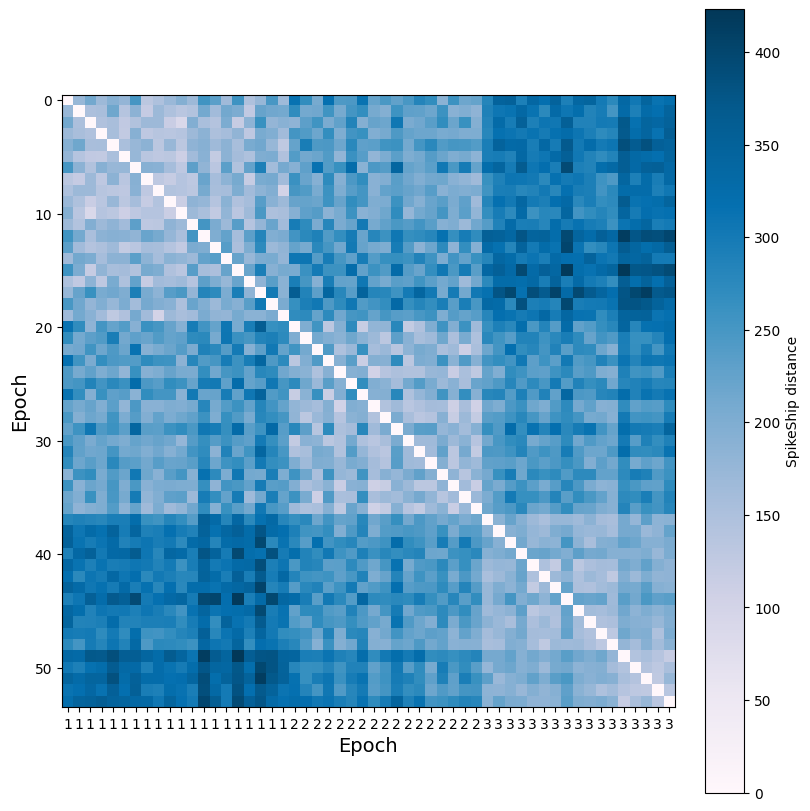

In [107]:
alpha = 0.5; marker = 'o';

# true labels sorting
#si = np.argsort(epoch_labels)

plt.figure(figsize=(8,8), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss[:54,:][:,:54], cmap='PuBu')
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 
plt.xticks(np.arange(0,54), epoch_labels[:54])

([<matplotlib.axis.XTick at 0x7f1d93e61210>,
 [Text(0, 0, '1'),
  Text(10, 0, '1'),
  Text(20, 0, '1'),
  Text(30, 0, '1'),
  Text(40, 0, '1'),
  Text(50, 0, '1'),
  Text(60, 0, '1'),
  Text(70, 0, '1'),
  Text(80, 0, '2'),
  Text(90, 0, '2'),
  Text(100, 0, '2'),
  Text(110, 0, '2'),
  Text(120, 0, '2'),
  Text(130, 0, '3'),
  Text(140, 0, '3'),
  Text(150, 0, '3'),
  Text(160, 0, '3'),
  Text(170, 0, '3')])

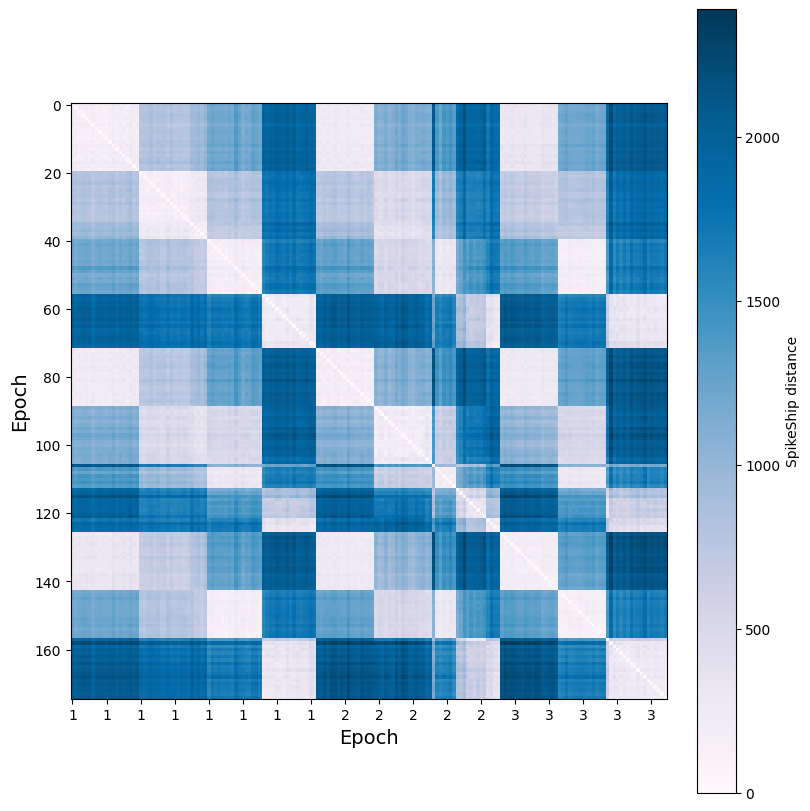

In [ ]:
alpha = 0.5; marker = 'o';

# true labels sorting
#si = np.argsort(epoch_labels)

plt.figure(figsize=(8,8), facecolor='w', constrained_layout=True)

# dissimilarity matrices (vis)
im0 = plt.imshow(spikeship_diss[:,si][si,:], cmap='PuBu')
plt.colorbar(label="SpikeShip distance")
plt.xlabel("Epoch", fontsize=14); plt.ylabel("Epoch", fontsize=14); 
plt.xticks(np.arange(0,175, 10), epoch_labels_tries[::10])

### Visualization of clusters by using SPOTDis and SpikeShip dissimilarity measures

In [36]:
import sys
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import hdbscan
from sklearn.manifold import TSNE

In [37]:
ss_dis_labels.shape

(176,)

In [38]:
clusterer = hdbscan.HDBSCAN(metric='precomputed')
ss_dis_labels = clusterer.fit_predict(spikeship_diss)

print(len(np.unique(ss_dis_labels)), 'clusters found (SpikeShip, neuron-specific flows)')

7 clusters found (SpikeShip, neuron-specific flows)


In [44]:
spikeship_embedding = TSNE(n_components=2, init='pca').fit_transform(spikeship_diss)
#spikeship_embedding   = TSNE(n_components=2).fit_transform(spikeship_diss)

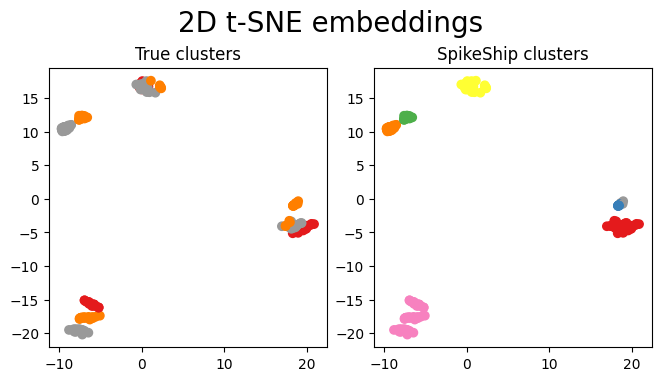

In [45]:
tPlot,axes = plt.subplots(
    figsize=(6.5,3.7), facecolor='w',nrows=1, ncols=2, sharex=False, sharey=False, constrained_layout=True)

plt.suptitle('2D t-SNE embeddings',fontsize=20)
axes[0].set_title('True clusters')
axes[0].scatter(spikeship_embedding[:, 0], spikeship_embedding[:, 1], cmap='Set1_r', c=epoch_labels)

axes[1].set_title('SpikeShip clusters')
axes[1].scatter(spikeship_embedding[:, 0], spikeship_embedding[:, 1], cmap='Set1_r', c=ss_dis_labels);


In [ ]:
stim_values = 

In [ ]:
# 2D tsne embedding (vis)
l_colors = ['royalblue', 'orange', 'green', 'purple']
for i in range(len(stim_values)):
    stim_val = stim_values[i]
    mask = (stim_labels == stim_val)
    axes[1].set_title('2D t-SNE Embedding', fontsize=fs)
    axes[1].scatter(emd_spikeship[mask, 0], emd_spikeship[mask, 1], s=20, alpha=0.5, label=stim_val)#, c=np.repeat(l_colors[i], np.sum(mask)), alpha=alpha, marker=marker, facecolors='none')
    axes[1].set_xlabel("1st Component", fontsize=fs); axes[1].set_ylabel("2nd Component", fontsize=fs)

_ = axes[1].legend(bbox_to_anchor=(1,1), frameon=False, title="Drifting gratings\n(degrees)")